In [45]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import re
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('D:\IMP  ML  PROJECTS\CAR PRICE PREDICTION\web scraping\MUMBAI\car_dataset_mumbai.csv')

In [5]:
count = 0
for col in df.columns:
    percentage = df[col].isnull().sum() / df[col].shape[0] * 100
    if percentage > 30:
        count += 1
print(f"Number of columns with more than 30% missing values: {count}")
print(f"Percentage of columns with above 30% missing values: {count / len(df.columns) * 100:.2f}%")

Number of columns with more than 30% missing values: 66
Percentage of columns with above 30% missing values: 57.89%


In [36]:
# .columns returns the index of column names, [:15] slices the first 15
first_15_columns = df.columns[:15].tolist()

print(first_15_columns)

['url', 'Registration Year', 'Insurance', 'Fuel Type', 'Seats', 'Kms Driven', 'RTO', 'Ownership', 'Engine Displacement', 'Transmission', 'Year of Manufacture', 'Engine', 'Ground Clearance', 'Power', 'Seating Capacity']


In [6]:
df.columns

Index(['url', 'Registration Year', 'Insurance', 'Fuel Type', 'Seats',
       'Kms Driven', 'RTO', 'Ownership', 'Engine Displacement', 'Transmission',
       ...
       'Drag Coefficient', 'Quarter Mile (Tested)', '3rd Gear (30-80kmph)',
       '4th Gear (40-100kmph)', 'Emission Control System',
       'Acceleration 0-60kmph', 'Petrol Mileage (ARAI)',
       'Petrol Fuel Tank Capacity (Litres)', 'Petrol City Mileage',
       'CNG Highway Mileage'],
      dtype='object', length=114)

## Data Cleaning

1. Registration Year

In [7]:
print(f"The number of missing values in the column 'Registration Year': {df['Registration Year'].isnull().sum()}\n")
print(df['Registration Year'].value_counts())

The number of missing values in the column 'Registration Year': 3

Registration Year
2011        297
2016        184
2019        182
2013        181
Aug 2017    175
           ... 
Nov 2007      1
Mar 2010      1
Nov 2024      1
Aug 2011      1
Aug 2010      1
Name: count, Length: 207, dtype: int64


In [8]:
df['Registration Year'].dtype

dtype('O')

In [9]:
def extract_month(text):
    month_map = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
        'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
        'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }
    # Convert input to string in case there are integers/NaNs
    text = str(text)
    
    # Check each month in our dictionary
    for month_name, month_digit in month_map.items():
        if month_name in text:
            return month_digit
            
    # Return None (nothing) if no month name is found
    return None

def extract_year(text):
    text = str(text)
    # Split the string by spaces and take the last part (works for "2013" and "Aug 2017")
    year_part = text.split()[-1]
    
    try:
        return int(year_part)
    except ValueError:
        return None 
    
# Apply the function to create the new column
df['Registration Month'] = df['Registration Year'].apply(extract_month)
df['Registration Year'] = df['Registration Year'].astype(str).apply(extract_year)

In [10]:
# Missing Values in Registration Year and Registration Month Column
print(f"The number of missing values in the column 'Registration Year': {df['Registration Year'].isnull().sum()}, ({(df['Registration Year'].isnull().sum() / df['Registration Year'].shape[0] * 100):.2f}%)")

print(f"The number of missing values in the column 'Registration Month': {df['Registration Month'].isnull().sum()}, ({(df['Registration Month'].isnull().sum() / df['Registration Month'].shape[0] * 100):.2f}%)")

The number of missing values in the column 'Registration Year': 3, (0.06%)
The number of missing values in the column 'Registration Month': 1410, (28.40%)


> Filling the missing values for Registration Month and Year Feautres

In [11]:
# 1. Get the list of existing (non-null) months
existing_months = df['Registration Month'].dropna()

# 2. Fill the missing (NaN) values by picking randomly from the existing months
df['Registration Month'] = df['Registration Month'].apply(
    lambda x: np.random.choice(existing_months) if pd.isnull(x) else x
)

# 3. Convert to int (now that there are no NaNs)
df['Registration Month'] = df['Registration Month'].astype(int)

# 4. Fill the missing values of 'Registration Year' feature with the mode of the feature
df['Registration Year'] = df['Registration Year'].fillna(df['Registration Year'].mode()[0])
df['Registration Year'] = df['Registration Year'].astype(int)

print(f"The number of missing values in the column 'Registration Year': {df['Registration Year'].isnull().sum()}")
print(f"The number of missing values in the column 'Registration Month': {df['Registration Month'].isnull().sum()}")

The number of missing values in the column 'Registration Year': 0
The number of missing values in the column 'Registration Month': 0


2. Insurance

In [12]:
df['Insurance'].value_counts()

Insurance
Comprehensive    1940
-                1715
Third Party      1083
Zero Dep          166
Not Available      60
Name: count, dtype: int64

In [13]:
# Replace the hyphen and 'Not Available' with 'Unknown'
df['Insurance'] = df['Insurance'].replace(['-', 'Not Available'], 'Unknown')

In [14]:
# number of missing values
print(f"The number of missing values in the column 'Insurance': {df['Insurance'].isnull().sum()}, {(df['Insurance'].isnull().sum() / df['Insurance'].shape[0] * 100):.2f}%")

The number of missing values in the column 'Insurance': 0, 0.00%


3. Fuel Type

In [15]:
df['Fuel Type'].value_counts()

Fuel Type
Petrol      3751
Diesel      1010
CNG          162
Electric      41
Name: count, dtype: int64

In [16]:
# number of missing values in Fuel Type
print(f"The number of missing values in the column 'Fuel Type': {df['Fuel Type'].isnull().sum()}, {(df['Fuel Type'].isnull().sum() / df['Fuel Type'].shape[0] * 100):.2f}%")

The number of missing values in the column 'Fuel Type': 0, 0.00%


4. Seats

In [17]:
df['Seats'].value_counts()

Seats
5 Seats    4359
7 Seats     439
8 Seats      71
6 Seats      45
4 Seats      42
2 Seats       2
Name: count, dtype: int64

In [18]:
def extract_seats(text):
    if pd.isnull(text) or text == '-':
        return None  # Handle missing or invalid values
    
    # Convert to string and take the first part
    number_part = str(text).split()[0]
    
    try:
        return int(number_part)
    except ValueError:
        return None

# Apply the function
df['Seats'] = df['Seats'].apply(extract_seats)

In [19]:
print(f"Number of missing values in the column 'Seats': {df['Seats'].isnull().sum()}, {(df['Seats'].isnull().sum() / df['Seats'].shape[0] * 100):.2f}%")

Number of missing values in the column 'Seats': 6, 0.12%


In [20]:
# Fill the missing values with the mode 
df['Seats'] = df['Seats'].fillna(df['Seats'].mode()[0])
print(f"Number of missing values in the column 'Seats': {df['Seats'].isnull().sum()}, {(df['Seats'].isnull().sum() / df['Seats'].shape[0] * 100):.2f}%")

Number of missing values in the column 'Seats': 0, 0.00%


5. Kms Driven

In [21]:
df['Kms Driven'].value_counts()

Kms Driven
1,60,000 Kms    210
60,000 Kms      173
1,00,000 Kms    166
30,000 Kms      148
1,50,000 Kms    121
               ... 
53,465 Kms        1
54,243 Kms        1
31,221 Kms        1
500 Kms           1
1,663 Kms         1
Name: count, Length: 1061, dtype: int64

In [22]:
def extract_kms(text):
    if pd.isnull(text) or text == '-':
        return None
    
    # 1. Remove commas
    # 2. Split to take the first part (the number)
    clean_text = str(text).replace(',', '').split()[0]
    
    try:
        return int(clean_text)
    except ValueError:
        return None

df['Kms Driven'] = df['Kms Driven'].apply(extract_kms)

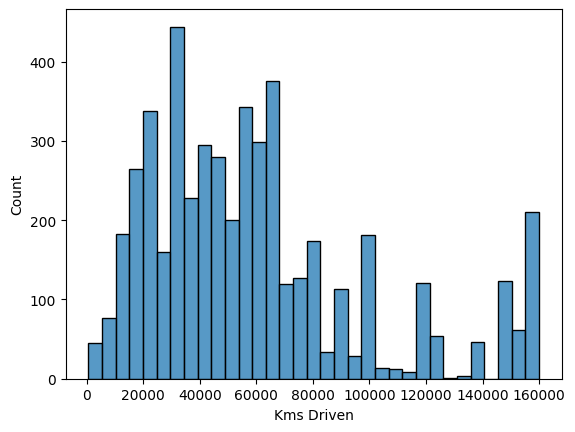

In [23]:
sns.histplot(df['Kms Driven'])
plt.show()

6. Ownership

In [24]:
print("Number of missing values in the column 'Ownership':", df['Ownership'].isnull().sum(), f"({(df['Ownership'].isnull().sum() / df['Ownership'].shape[0] * 100):.2f}%)", sep=' ')

Number of missing values in the column 'Ownership': 3 (0.06%)


In [25]:
# Fill Missing with the Mode
df['Ownership'] = df['Ownership'].fillna(df['Ownership'].mode()[0])
print("Number of missing values in the column 'Ownership':", df['Ownership'].isnull().sum(), f"({(df['Ownership'].isnull().sum() / df['Ownership'].shape[0] * 100):.2f}%)", sep=' ')

Number of missing values in the column 'Ownership': 0 (0.00%)


In [26]:
df['Ownership'].value_counts()

Ownership
First Owner     3411
Second Owner    1277
Third Owner      215
Fifth Owner       60
Fourth Owner       1
Name: count, dtype: int64

In [27]:
# Define the mapping dictionary
ownership_map = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth Owner': 4,
    'Fifth Owner': 5
}

# Apply the mapping to the column
df['Ownership'] = df['Ownership'].map(ownership_map).astype(int)

7. Engine Displacement

In [28]:
print("Number of missing values in the column 'Engine Displacement':", df['Engine Displacement'].isnull().sum(), f"({(df['Engine Displacement'].isnull().sum() / df['Engine Displacement'].shape[0] * 100):.2f}%)", sep=' ')

Number of missing values in the column 'Engine Displacement': 42 (0.85%)


In [29]:
# Filling the missing values with the mode
df['Engine Displacement'] = df['Engine Displacement'].fillna(df['Engine Displacement'].mode()[0])

In [30]:
df['Engine Displacement'].value_counts()

Engine Displacement
1197 cc    881
1199 cc    538
1497 cc    383
1248 cc    364
998 cc     354
          ... 
1047 cc      1
4367 cc      1
1193 cc      1
1186 cc      1
2354 cc      1
Name: count, Length: 88, dtype: int64

In [31]:
def extract_engine(text):
    # Split the string and take the first part (the number)
    number_part = str(text).split()[0]
    
    try:
        return int(number_part)
    except ValueError:
        return None

df['Engine Displacement'] = df['Engine Displacement'].apply(extract_engine)

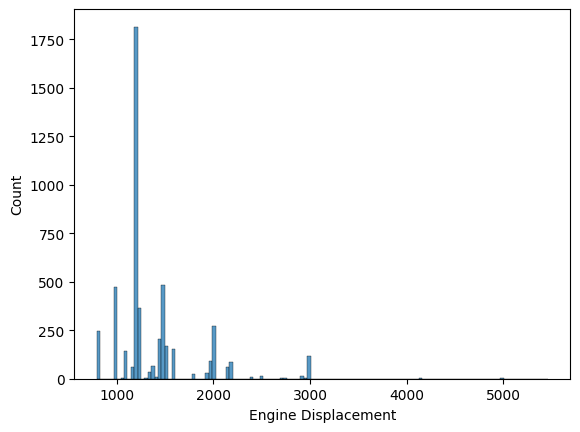

In [32]:
sns.histplot(df['Engine Displacement'])
plt.show()

---

In [33]:
def smart_fill_categorical(dataframe, column_name):
    '''
    This function will fill the missing values in the given column with the mode or random values based on the percentage of missing values
    '''
    # Calculate missing percentage
    missing_count = dataframe[column_name].isnull().sum()
    total_rows = dataframe.shape[0]
    perct_missing = (missing_count / total_rows) * 100
    
    print(f"Processing '{column_name}': {missing_count} missing ({perct_missing:.2f}%)")
    
    if missing_count == 0:
        print("No missing values found.")
        return dataframe
    
    if perct_missing < 10:
        # Method 1: Mode
        fill_val = dataframe[column_name].mode()[0]
        dataframe[column_name] = dataframe[column_name].fillna(fill_val)
        print(f"Filled with Mode: {fill_val}")
        
    elif perct_missing < 30:
        # Method 2: Random Distribution
        existing_values = dataframe[column_name].dropna()
        dataframe[column_name] = dataframe[column_name].apply(
            lambda x: np.random.choice(existing_values) if pd.isnull(x) else x
        )
        print("Filled using Random Distribution")
        
    else:
        # Method 3: Constant
        dataframe[column_name] = dataframe[column_name].fillna('Unknown')
        print("Filled with 'Unknown' label")
        
    return dataframe

---

8. Transmission

In [34]:
# Use it for Transmission
df = smart_fill_categorical(df, 'Transmission')

Processing 'Transmission': 0 missing (0.00%)
No missing values found.


In [35]:
df['Transmission'].value_counts()

Transmission
Manual       3172
Automatic    1792
Name: count, dtype: int64

9. Power

In [43]:
df['Power'].value_counts()

Power
74 bhp        338
73 bhp        180
88.76 bhp     171
68.05 bhp     137
81.86 bhp     133
             ... 
473.38 bhp      1
200 bhp         1
74.41 bhp       1
147.9 bhp       1
187.4 bhp       1
Name: count, Length: 280, dtype: int64

In [46]:
def extract_power(text):
    if pd.isnull(text) or text == '-':
        return None
    
    # regex to find a number that may include a decimal point
    # \d+ matches digits, \.? matches an optional decimal, \d* matches optional following digits
    match = re.search(r'(\d+\.?\d*)', str(text))
    
    if match:
        return float(match.group(1))
    return None

# Apply the function to the Power column
df['Power'] = df['Power'].apply(extract_power)

In [47]:
df = smart_fill_categorical(df, 'Power')

Processing 'Power': 253 missing (5.10%)
Filled with Mode: 74.0


<Axes: xlabel='Power', ylabel='Count'>

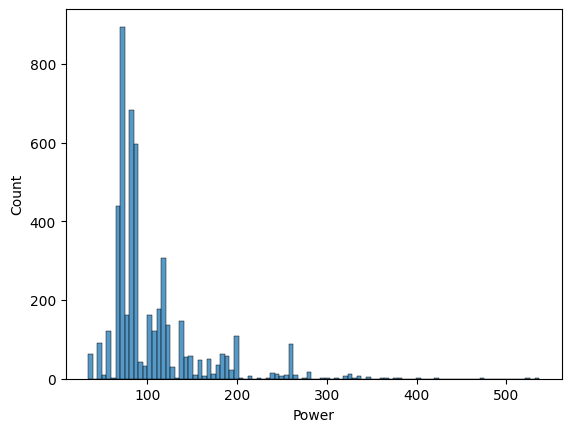

In [48]:
sns.histplot(df['Power'])

<span style="color:yellow;">Fill the missing values of 'number of seats' column with these values</span>

In [ ]:
df['Seating Capacity'].value_counts(
    
    
)

Seating Capacity
5.0    4359
7.0     439
8.0      71
6.0      45
4.0      42
2.0       2
Name: count, dtype: int64

In [39]:
# Check how many rows are different
difference = (df['Registration Year'] - df['Year of Manufacture']).value_counts()
print(difference)

 0     4671
 1      285
-8        3
 2        1
 3        1
 12       1
 10       1
 6        1
Name: count, dtype: int64
